# An Introduction to Exponential Smoothing in Python

In [2]:
# imports
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

from pylab import rcParams # conda install pylab

## Forecasting: An Intro

Q: What if I wanted to forecast beer sales knowing the weather forecast? <br>
Q: What if I wanted to forecast beer sales knowing when the baseball and football seasons start and end? <br>
Q: What if I wanted to forecast beer sales knowing both? <br>
Q: We focused on forecasting demand for beer products. What other fields use forecasting?

In [4]:
# read in data
df = pd.read_table('data/birth.txt')
birth = df.set_index(pd.DatetimeIndex(start='1/1/1980', end='12/31/2010', freq='M'))
birth.head()

,num_births
1980-01-31,295
1980-02-29,286
1980-03-31,300
1980-04-30,278
1980-05-31,272


## Simple Forecasts

### Naive
("only yesterday matters")
<br>
$\displaystyle{x}_{t}=x_{t-1}+\epsilon_t$ (model) <br>
$\displaystyle\hat{x}_{t,t+1}=x_t$ (forecast)

In [5]:
# making forecasts of US births for the census bureau :o
df = birth.copy()
df['naive'] = df['num_births'].shift() # for visualization, shift 30

### Cumulative
("history matters") 
<br>
$\displaystyle{x}_{t}=a+\epsilon_t$ <br>
$\displaystyle\hat{x}_{t,t+1}=\frac{\sum_{i=1}^{t}{x_i}}{t}$

In [6]:
def cumulative(series):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append((series[:n+1].mean()))
    return result

df['cumulative'] = cumulative(df['num_births'])

In [13]:
df['cum2'] = df['num_births'].mean()

### Moving Average
("I select how much matters"):
<br>
$\displaystyle{x}_{t}=a+\epsilon_t$ <br>
$\displaystyle\hat{x}_{t,t+1}=\frac{\sum_{i=t+1-M}^{t}{x_i}}{M}$

In [9]:
df['moving_average'] = df['num_births'].rolling(window=10).mean()

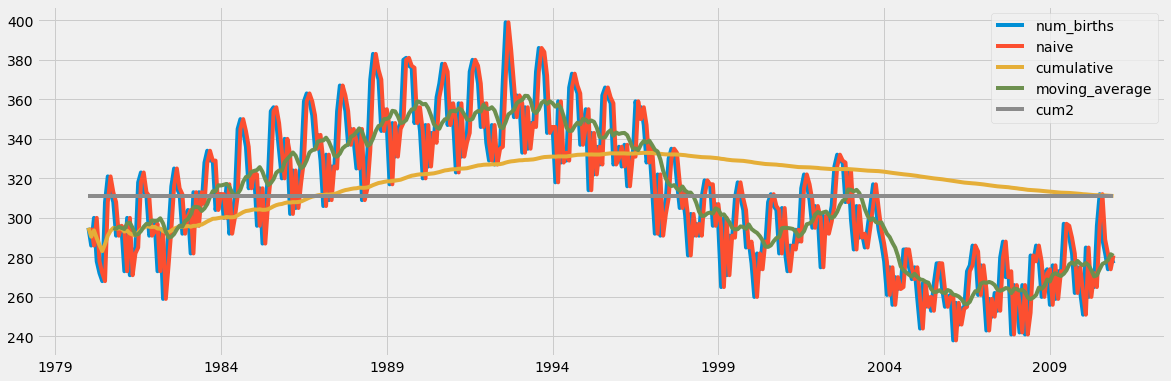

In [14]:
# see all of them together
plt.style.use('fivethirtyeight')
ax = df.plot(figsize=(18, 6), fontsize=14)
plt.show()

Q: What would happen to the green line if I set the M in moving average to 50?

## Exponential Smoothing

### Decomposing Time Series

can have trend, seasonal, cycles, residual <br>
seasonal can be additive or multiplicative (can use different forecasting methods accordingly) <br>
statsmodel has a seasonal_decompose() function, it will show observed, can call trend, seasonal, and residual

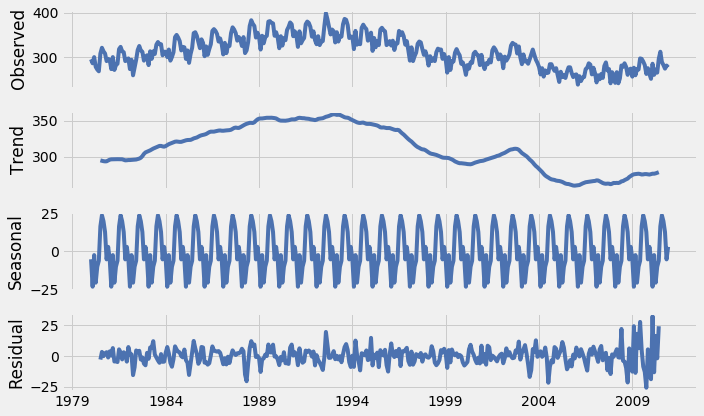

In [59]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6

from statsmodels.tsa.seasonal import seasonal_decompose
result_a = seasonal_decompose(birth, model='additive')
fig = result_a.plot()
plt.show()

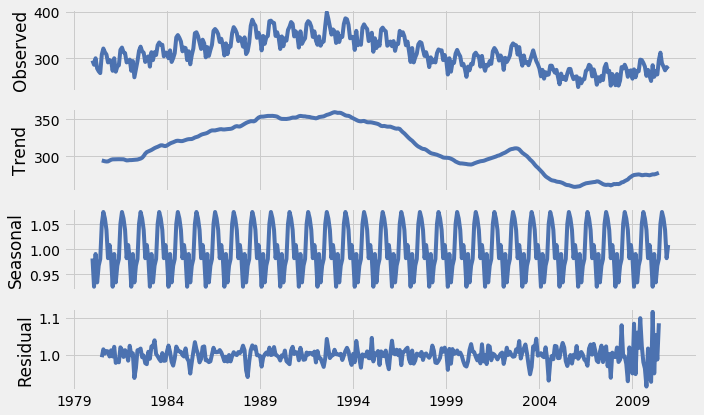

In [57]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6

from statsmodels.tsa.seasonal import seasonal_decompose
result_m = seasonal_decompose(birth, model='multiplicative')
fig = result_m.plot()
plt.show()

Note that the various components are on different scale. <br>
Q: Which one shall we use to model this one?

### Simple Exponential Smoothing (level)

Simple forecasts differ in how much history they use but they treat all of them the same. Exponential smoothing treats more recent data differently. Note: python code below (so that you can see what's going on), you can also use statsmodels: http://www.statsmodels.org/dev/tsa.html

$\displaystyle x_{t}=a+\epsilon_t$ (model) <br>
$\displaystyle\hat{x}_{t,t+1}=\alpha x_t+(1-\alpha)\hat{x}_{t-1,t}$ (forecast) <br>
only smoothing param: $\alpha$

In [ ]:
# note: additive
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

$\alpha=1$ leads to fast smoothing (nervous, volatile, naive)
$\alpha=0$ leads to slow smoothing (calm, staid, cumulative)

Q: How do I know it is additive?

### Holt (level + trend)

$\displaystyle x_{t}= a+bt+\epsilon_t$ <br>
$\displaystyle\hat{x}_{t,t+\tau}=\hat{a}_t+\tau\hat{b}_t$ <br>
<br>
$\displaystyle\hat{a}_t=\alpha x_t+(1-\alpha)(\hat{a}_{t-1}+\hat{b}_{t-1})$ <br>
<br>
$\displaystyle\hat{b}_t=\beta (\hat{a}_t - \hat{a}_{t-1}) + (1-\beta) \hat{b}_{t-1}$ <br>
<br>
smoothing params: $\alpha$ (level), $\beta$ (trend)

In [ ]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1: # initialize
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # we are forecasting
          value = result[-1]
        else:
          value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend) # a-hat at t
        trend = beta*(level-last_level) + (1-beta)*trend # b-hat at t
        result.append(level+trend)
    return result

In [ ]:
# note: you can dampen trends adding omega
def double_exponential_smoothing_damped(series, alpha, beta, omega):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1: # initialize
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # we are forecasting
          value = result[-1]
        else:
          value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level + omega*trend) # a-hat at t
        trend = beta*(level-last_level) + (1-beta)*omega*trend # b-hat at t
        result.append(level+trend)
    return result

Q: Is this additive or multiplicative? How do I know?

### Double Exponential Smoothing (level + season)

$\displaystyle x_{t}= a{F}_{t}+\epsilon_t$ <br>
$\displaystyle\hat{x}_{t,t+\tau}=\hat{a}_t*\tau\hat{F}_{t+\tau P}$ <br>
<br>
$\displaystyle\hat{a}_t=\alpha (\frac{x_t}{\hat{F}_{t-P}}) + (1-\alpha)\hat{a}_{t-1}$ <br>
<br>
$\displaystyle\hat{F}_t=\gamma (\frac{x_t}{\hat{a}_t}) + (1-\gamma) \hat{F}_{t-P}$ <br>
<br>
smoothing params: $\alpha$ (level), $\gamma$ (season)

In [ ]:
# note: multiplicative
# slen: season length
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

def double_exponential_smoothing_season(series, slen, alpha, gamma):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1: # initialize
            level, seasonals = series[0], initial_seasonal_components(series, slen)
        if n >= len(series): # we are forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*(value/seasonals[i%slen]) + (1-alpha)*(level)
        seasonals[i%slen] = gamma*(value/smooth) + (1-gamma)*seasonals[i%slen]
        result.append(level*seasonals)
    return result

Q: What do you need to change here to make it additive?

### Holt-Winters (level + trend + season)

$\displaystyle x_{t}=(a+bt){F}_{t}+\epsilon_t$ <br>
$\displaystyle\hat{x}_{t,t+\tau}=\hat{a}_t+\tau\hat{F}_{t+\tau P}$ <br>
<br>
$\displaystyle\hat{a}_t=\alpha (\frac{x_t}{\hat{F}_{t-P}}) + (1-\alpha)\hat{a}_{t-1}$ <br>
<br>
$\displaystyle\hat{F}_t=\gamma (\frac{x_t}{\hat{a}_t}) + (1-\gamma) \hat{F}_{t-P}$ <br>
<br>
smoothing params: $\alpha$ (level), $\gamma$ (season)

In [ ]:
# multiplicative seasonality & additive trend
def initial_trend(series, slen):
    sum = 0.0
    for i in range(slen):
        sum += float(series[i+slen] - series[i]) / slen
    return sum / slen

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val/seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend # same as level+trend
            seasonals[i%slen] = gamma*(val/smooth) + (1-gamma)*seasonals[i%slen] # same as level+season
            result.append((smooth+trend)*seasonals[i%slen])
    return result

Q: Ok, one last time: how do I know it is multiplicative seasonality and additive trend?

### A few points about exponential smoothing

The usual train-test is now initialize-train-test:
* initialize: estimate level, trend, seasonality (needs to be cleaned of all non-repeating events)
* train: fine-tune smoothing factors
* test: evaluate the quality of forecasts

initializing: 
* simple (level): use cumulative on initializing dataset
* Holt (level+trend): use regression to find level and trend estimates <br>
with seasonality, it gets complicated <br>
* double (level + season): for level, use cumulative <br>
season = moving average season (window of slen) / cumulative <br>
* Holt-Winters: <br>
season_estimate = value / moving average season (window of slen) <br>
find seasonality index: average season_estimates for common seasons <br>
divide observations by seasonality index <br>
use regression on deseasonalized observations to find level and trend <br>

training:
finetuning smoothing parameters (see reasonable parameters in slide below):
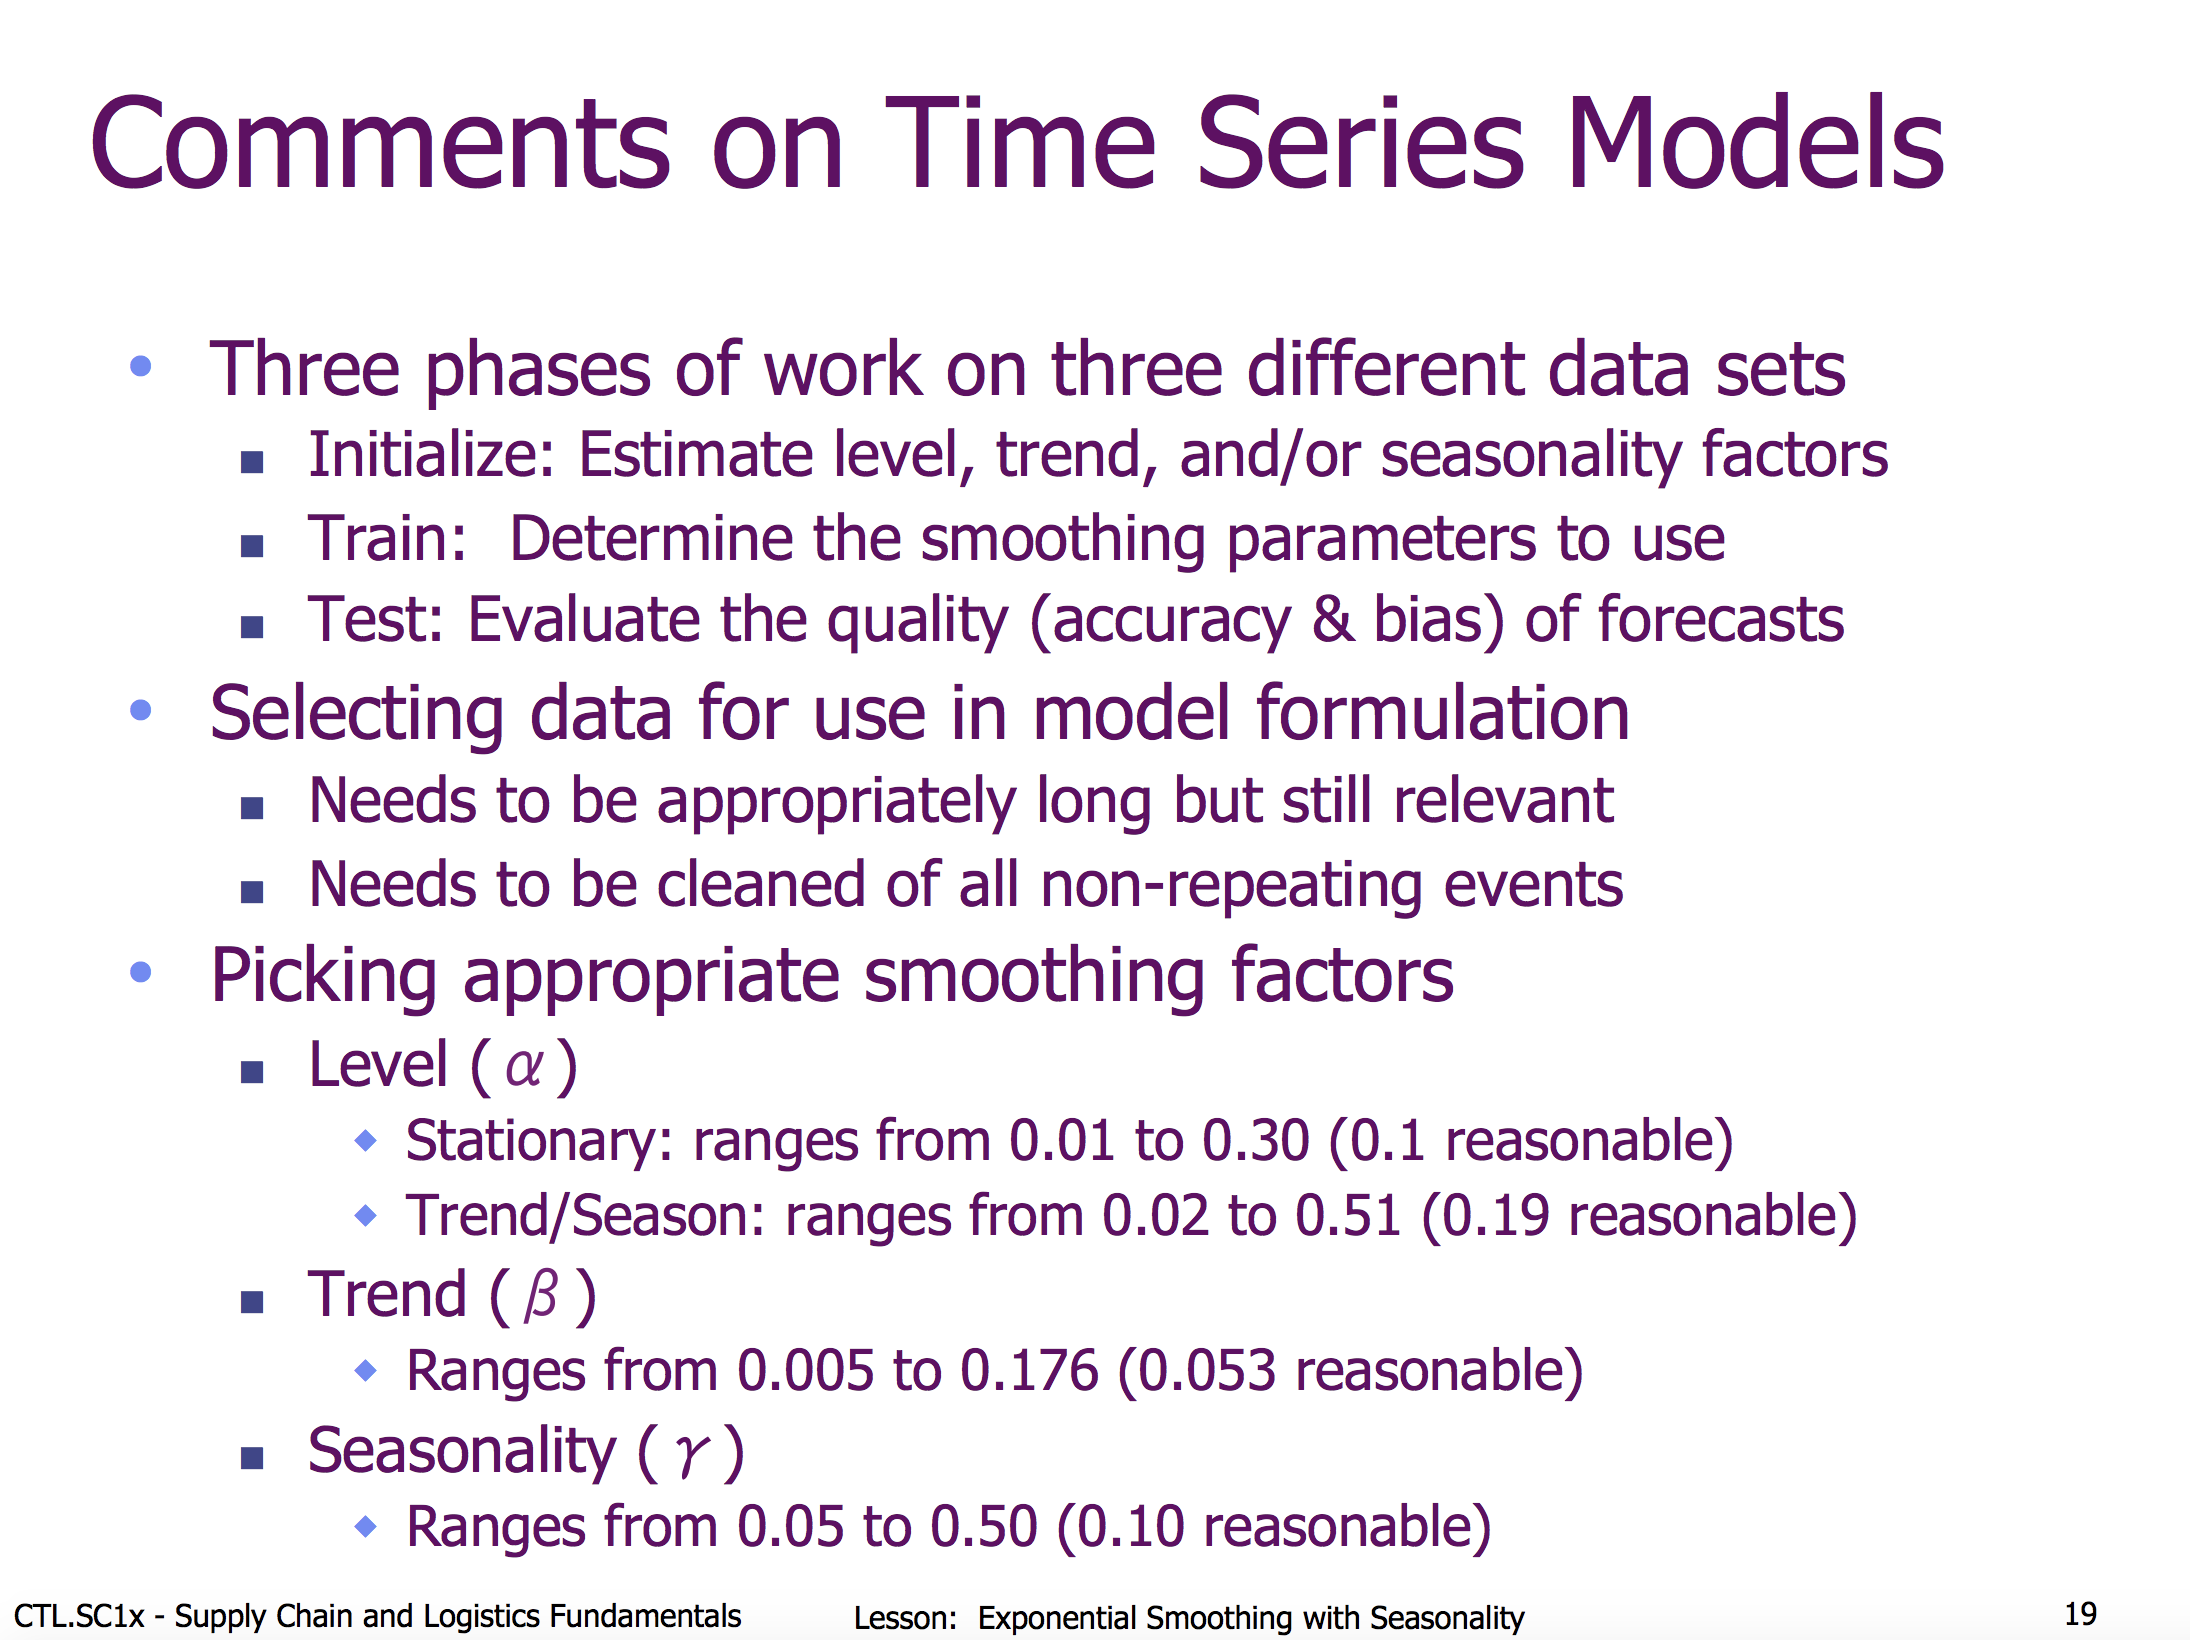

This slide is from Professor Chris Caplice and the outstanding MITx course, Supply Chain Fundamentals (here: https://www.edx.org/course/supply-chain-fundamentals)

Finally, with seasonality additive and multiplicative, plus trend dampening thrown in, we only covered the tip of the iceberg... For more on this topic, see the fantastic online text book "Forecasting: Principles and Practice" here: https://otexts.org/fpp2/taxonomy.html
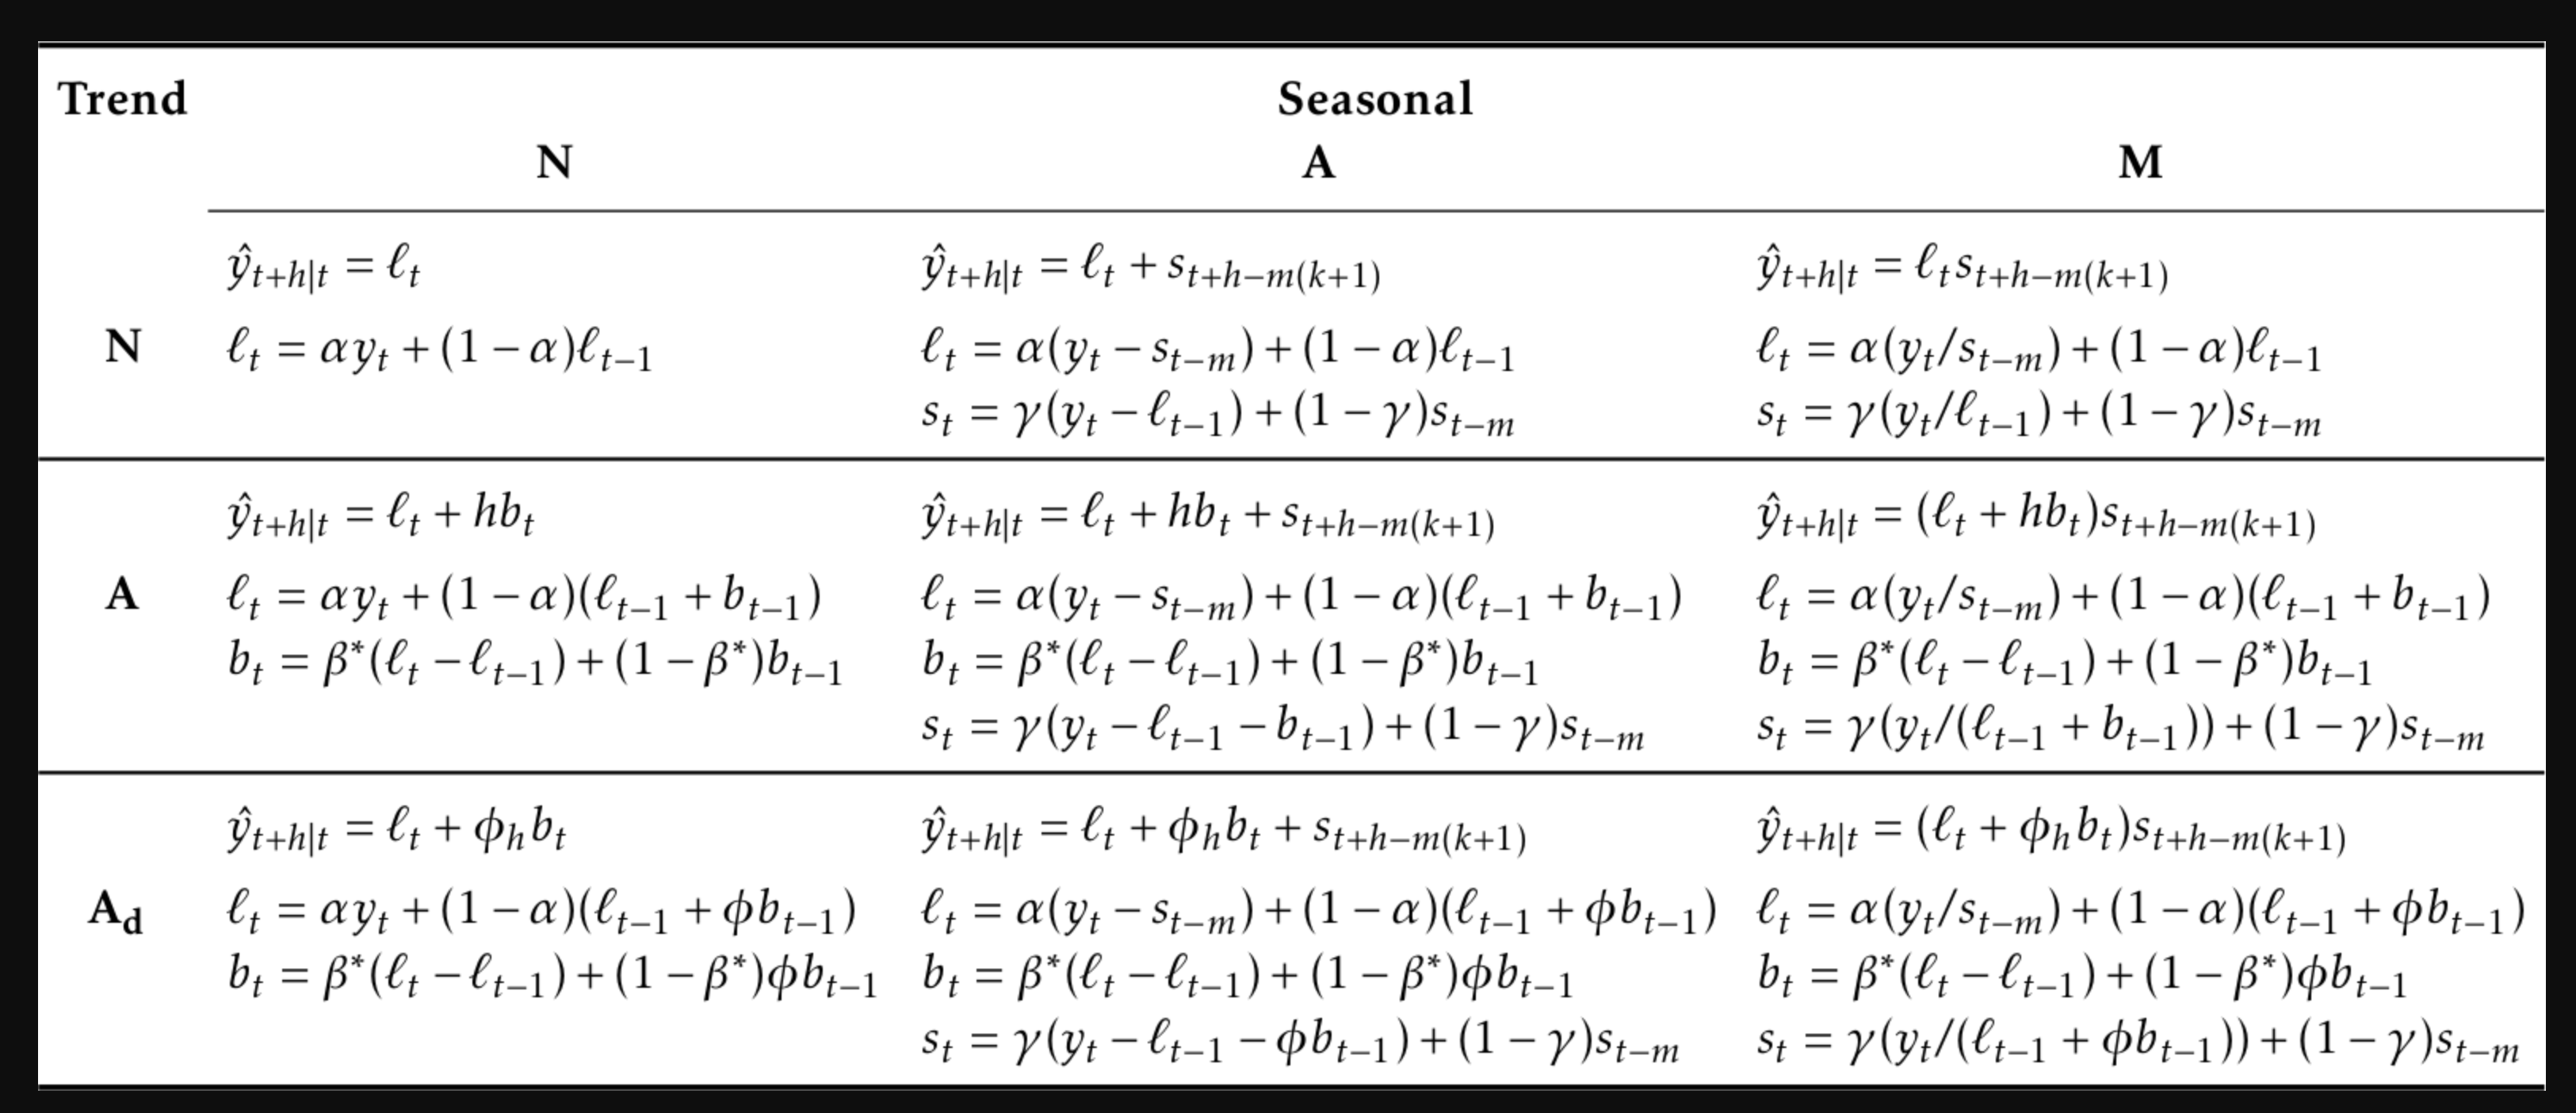

Q: So when do you use exponential smoothing vs. ARIMA?

### Forecasting metrics

Scale dependent errors (comparing forecast methods on a single data set / cannot be used to make comparisons between series that are on different scales): <br>
MD (mean deviation): $\frac{A_t-F_t}{n}$ <br>
MAD (mean absolute deviation, also called MAE):
$\frac{|A_t-F_t|}{n}$ <br>
MSE (mean squared error):
$\frac{(A_t-F_t)^2}{n}$ <br>
RMSE (root mean squared error):
$\sqrt{\frac{(A_t-F_t)^2}{n}}$ <br>
Percentage errors (used to compare forecast performance between different data sets):
MPE, MAPE <br>
also scaled errors

## A few resources:

General: <br>
A recent blog from Uber Engineering on forecasting in general: https://eng.uber.com/forecasting-introduction/ <br>
Another general intro with several chapters (but ES): http://dacatay.com/data-science/comprehensive-guide-time-series-analytics-visualization-prediction-python/ <br>

Exponential Smoothing: <br>
A good overview of exponential smoothing from Machine Learning Mastery: https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/ <br>
And another one from Analytics Vidhya:https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/ <br>
A three-part blog series I used extensively: https://grisha.org/blog/2016/01/29/triple-exponential-smoothing-forecasting/ <br>
Anotrher implementation of ES in Python: https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-time-series-analysis-in-python-a270cb05e0b3
A great course starting on December 26: https://www.edx.org/course/supply-chain-fundamentals <br>

Also, I added a notebook in the repo with ES implementations using statsmodels. That notebook has additional resources on time series as well.